# Exercise 2

In [1]:
# GDrive - Authentication required
from google.colab import drive
from google.colab.patches import cv2_imshow
import sys, os
drive.mount('/content/gdrive')

# Change the current working directory
dir_path = '/content/gdrive/My Drive/ML_exercise'
sys.path.append(dir_path)
os.chdir(dir_path)

Mounted at /content/gdrive


In [2]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import tensorflow as tf
# The check.py be used for selftesting throughout the lab
from scripts.check import *

## 1- Part one

### 1-1. Data Preprocessing

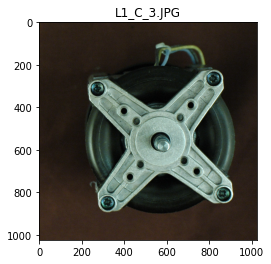

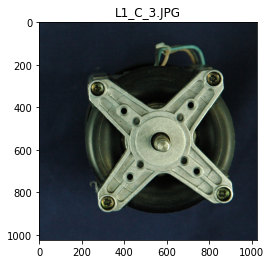

In [4]:
# Loading one image in top view
path = "./data/top/L1_C_3.JPG"
img = cv2.imread(path)
img.shape

# image type
#type(img)

# Plot image
plt.title(path.split('/')[-1]) # Set the filename as image title
plt.imshow(img) # Display the image
plt.show()

# converting images' channels (RGB)
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.title(path.split('/')[-1])
plt.imshow(img)
plt.show()

#### Function for loading multiple images
loading features (images) and thier associated labels (classes) into to seperate lists:

In [5]:
import glob

def get_label_from_name(path):
    if "_C_" in path:
        return "Complete"
    if "_MC_" in path:
        return "Missing cover"
    if "_MS_" in path:
        return "Missing screw"
    if "_NS_" in path:
        return "Not screwed"
    return "n/a" # TODO: Raise error

def load_features_labels(folder, size = (64,32), flatten = True, color = False, identifiers=['NS', 'MS', 'MC', 'C']):
    features, labels = [], [] # Empty lists for storing the features and labels
    # Iterate over all imagefiles in the given folder
    for file in glob.glob(folder + "/*.JPG"):
        if any(identifier in file for identifier in identifiers):
            
            img=cv2.imread(file)
            img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            features.append(img)
            labels.append(get_label_from_name(file))

    return features, labels # Return results

>If everything works as expected, the function should load 117 features and labels.

In [6]:
features, labels = load_features_labels("./data/top")
print("Number of features:", len(features))
print("Number of labels:", len(labels))

################
# Quality gate #
################
quality_gate_111(features, labels)

Number of features: 117
Number of labels: 117


'Quality gate passed :)'

#### Image Preprocessing
Includes modifying images' size (resucing image resolution), color (RGB to BW) and shape (2.5D to 1D) 

In [7]:
def  image_preprocessing ( img ,  size  = ( 8 , 8 ),  flatten  =  True ,  color  =  False ):
    img = cv2.resize(img, size)
    if  not  color:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if  flatten:
        img = img.reshape( -1 )
    return  img

In [8]:
def load_features_labels(folder, size = (64,32), flatten = True, color = False, identifiers=['NS', 'MS', 'MC', 'C']):
    features, labels = [], [] # Empty lists for storing the features and labels
    # Iterate over all imagefiles in the given folder
    for file in glob.glob(folder + "/*.JPG"):
        if any(identifier in file for identifier in identifiers):
            labels.append(get_label_from_name(file))

            img=cv2.imread(file)
            #img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img=image_preprocessing(img, size= size, flatten= flatten, color= color)
            features.append(img)
            
    return features, labels # Return results

In [9]:
from numpy.core.fromnumeric import size
################
# Quality gate #
################

features, labels = load_features_labels( "./data/top" , size=( 8 ,  8 ), flatten= True , color= False )
print("Number of features:", len(features))
print("Number of labels:", len(labels))

quality_gate_112(features, labels)

Number of features: 117
Number of labels: 117


'Quality gate passed :)'

## Section 1-2: First data analysis
Before diving into machine learning, we'll have a look at the data. With the snippet below you can visualize a sample of the image data available in this lab. It can be observed that the class *missing cover* is rather distinct to the remaining classes, as the large black plastic cover is missing, exposing the copper wires. The defect *missing screw* is definitely harder to spot as the screws are rather small objects and the color difference between the screw and the empty hole is rather subtle. Finally, the defect *not screwed* can only be seen as some of the screws are not in the shade of the respective hole, thus indicating they are not screwed in all the way.

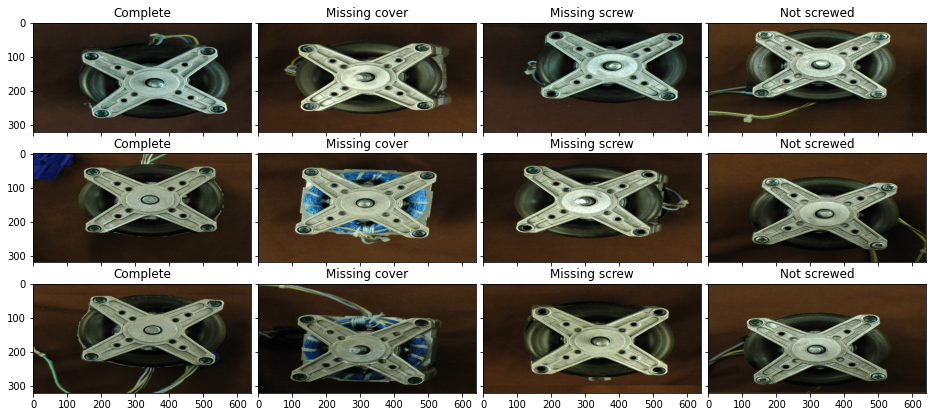

In [10]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(16, 12))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 4), axes_pad=(0.1, 0.3))

features, labels = load_features_labels("./data/top", size=(640, 320), flatten=False, color=True)
classes = ['Complete', 'Missing cover', 'Missing screw', 'Not screwed']
for i, ax in enumerate(grid):
    selectedClass = classes[i%4] # Select class
    images = np.array(features)[np.array(labels)==selectedClass] # Preselect images based on class
    image = images[i//4] # Select image 
    ax.imshow(image) # Plot image
    ax.set_title(selectedClass) # Assign class as image title
plt.show()

#### The chart below indicates the classes' distribution 

In [11]:
from collections import Counter
print(Counter(labels))

Counter({'Not screwed': 47, 'Missing screw': 42, 'Missing cover': 22, 'Complete': 6})


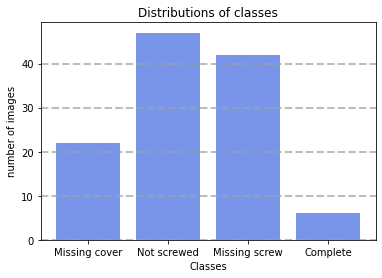

In [12]:
data = [data_distribution for data_distribution in Counter(labels).values()]
classes=[data_classes for data_classes in Counter(labels).keys()]

plt.title('Distributions of classes')
plt.xlabel('Classes')
plt.ylabel('number of images')
plt.bar(classes, data, color='royalblue', alpha=0.7)
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.show()

### 1-3. Image classification using Support Vector Machines

In [13]:
features, labels = load_features_labels("./data/top", size=(16,16), color=True, flatten=True, identifiers=['MC', 'MS', 'C'])
features = np.asarray(features)
labels = np.asarray(labels)
print("Shape feature vector:", features.shape)
print("Shape label vector:", labels.shape)

Shape feature vector: (70, 768)
Shape label vector: (70,)


In [14]:
# splitting dataset into training and test sets

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=0.7, stratify=labels, random_state=42)


################
# Quality gate #
################

quality_gate_13(X_train, X_test)

'Quality gate passed :)'

In [15]:
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_sample_weight
clf = SVC(kernel="rbf", gamma=0.01, C=0.0003) # Initialize the SVM
clf.fit(X_train, y_train, sample_weight=compute_sample_weight('balanced', y_train)) # Train the SVM
print("Score:", clf.score(X_test, y_test)) # Test the model

Score: 0.6190476190476191


               precision    recall  f1-score   support

     Complete       0.00      0.00      0.00         2
Missing cover       0.00      0.00      0.00         6
Missing screw       0.62      1.00      0.76        13

     accuracy                           0.62        21
    macro avg       0.21      0.33      0.25        21
 weighted avg       0.38      0.62      0.47        21



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


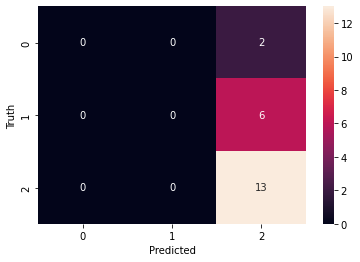

In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, clf.predict(X_test))
ax=sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
print(classification_report(y_test, clf.predict(X_test)))

### 1-4. Image classification with artificial neural networks

#### a) Using fully connected ANNs

In [17]:
features, labels = load_features_labels("./data/top", size=(128,128), color=True, flatten=True, identifiers=['MC', 'MS', 'C'])
features = np.asarray(features)
labels = np.asarray(labels)
print("Shape feature vector:", features.shape)
print("Shape label vector:", labels.shape)

Shape feature vector: (70, 49152)
Shape label vector: (70,)


In [18]:
# Splitting dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=0.7, stratify=labels, random_state=42)

In [19]:
# OnHot encoding on labels
# The sklearn preprocessing library contains a variety of useful data preprocessing tools such as one hot encoding
from sklearn.preprocessing import OneHotEncoder
# Display the first label before encoding
print("Label of first sample before OneHot encoding:", y_train[0])
# Create the encoder object
enc = OneHotEncoder(sparse=False) # Generate Encoder
# With the fit_transform function, the encoder is fitted to the existing labels and transforms the dataset into its binary representation
y_train = enc.fit_transform(y_train.reshape(-1, 1))
# Display the first label after encoding
print("Label of first sample after OneHot encoding:", y_train[0])
# Data preprocessing should always be fitted on the training dataset, but applied to both, the training and the testing dataset. Thus the fit_transform function is only applied to the training dataset, while the the test dataset is transformed using the transform function and the fitted preprocessing module
y_test = enc.transform(y_test.reshape(-1, 1))

Label of first sample before OneHot encoding: Missing cover
Label of first sample after OneHot encoding: [0. 1. 0.]


In [20]:
# Build the model
from keras.models import Sequential
from keras.layers import Dense, Activation, Input, Dropout

model = Sequential()
model.add(Dense(32, input_shape = X_train[0].shape))
model.add(Activation("relu"))
model.add(Dense(16))
model.add(Activation("relu"))
model.add(Dense(y_train[0].shape[0]))
model.add(Activation("softmax"))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                1572896   
                                                                 
 activation (Activation)     (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 activation_1 (Activation)   (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 51        
                                                                 
 activation_2 (Activation)   (None, 3)                 0         
                                                                 
Total params: 1,573,475
Trainable params: 1,573,475
Non-

In [21]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

In [22]:
# fit model
model.fit(X_train, y_train, epochs = 20, batch_size = 8, validation_split=0.2, verbose = 1)

Epoch 1/20
5/5 [==============================] - 1s 60ms/step - loss: 1613.9093 - accuracy: 0.3846 - val_loss: 2316.2397 - val_accuracy: 0.6000
Epoch 2/20
5/5 [==============================] - 0s 15ms/step - loss: 1868.0901 - accuracy: 0.3077 - val_loss: 1516.4073 - val_accuracy: 0.6000
Epoch 3/20
5/5 [==============================] - 0s 16ms/step - loss: 964.3767 - accuracy: 0.5897 - val_loss: 252.3890 - val_accuracy: 0.6000
Epoch 4/20
5/5 [==============================] - 0s 17ms/step - loss: 150.4058 - accuracy: 0.5897 - val_loss: 101.7418 - val_accuracy: 0.5000
Epoch 5/20
5/5 [==============================] - 0s 16ms/step - loss: 89.1845 - accuracy: 0.6667 - val_loss: 60.9967 - val_accuracy: 0.8000
Epoch 6/20
5/5 [==============================] - 0s 17ms/step - loss: 34.3172 - accuracy: 0.7949 - val_loss: 76.9432 - val_accuracy: 0.6000
Epoch 7/20
5/5 [==============================] - 0s 15ms/step - loss: 23.8921 - accuracy: 0.8205 - val_loss: 91.5494 - val_accuracy: 0.7000
E

In [23]:
#Evaluation
def evaluate_model(X_test, y_test, model):
    import seaborn as sns
    from sklearn.metrics import confusion_matrix, classification_report
    
    y_pred = model.predict(X_test)
    res = np.zeros_like(y_pred)
    for i in range(len(np.argmax(y_pred, axis=1))):
        res[i, np.argmax(y_pred,axis=1)[i]]=1
    y_pred = res
    cm = confusion_matrix(enc.inverse_transform(y_test), enc.inverse_transform(y_pred))
    ax=sns.heatmap(cm, annot=True)
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    print(classification_report(enc.inverse_transform(y_test), enc.inverse_transform(y_pred), zero_division=0))

               precision    recall  f1-score   support

     Complete       0.00      0.00      0.00         2
Missing cover       0.00      0.00      0.00         6
Missing screw       0.62      1.00      0.76        13

     accuracy                           0.62        21
    macro avg       0.21      0.33      0.25        21
 weighted avg       0.38      0.62      0.47        21



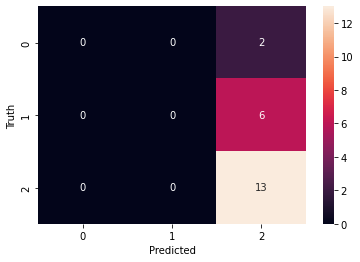

In [24]:
evaluate_model(X_test, y_test, model)

> Using the ANN with the given parameters, no training can be observed. This can be seen both in the low prediction accuracy on the validation data, as well as the confusion matrix, showing only one class being predicted.

> A potential explanation might be the relation of high amounts of free parameters (> 6 million) with the low amount of training data (~80 images). This low volume of training data might just not be enough to fit that many parameters. Also, the network architecture might not be optimized regarding the respective problems.

#### b) Using CNNs

In [25]:
features, labels = load_features_labels("./data/top", size=(512,512), color=True, flatten=False, identifiers=['MC', 'MS', 'C'])
features = np.array(features) # Datatype conversion of feature vector from list to array
labels = np.array(labels) # Datatype conversion of label vector from list to array
print("Shape feature vector:", features.shape)
print("Shape label vector:", labels.shape)

Shape feature vector: (70, 512, 512, 3)
Shape label vector: (70,)


In [40]:
#######################################
# Please complete the following lines #
#######################################

def split_data(features, labels):
    return train_test_split(features, labels, train_size=0.8, stratify=labels, random_state=42)

def encode_data(y_train, y_test):
    # Create the encoder object
    ENC = OneHotEncoder(sparse=False) # Generate Encoder
    # With the fit_transform function, the encoder is fitted to the existing labels and transforms the dataset into its binary representation
    y_train = ENC.fit_transform(y_train.reshape(-1, 1))
    # Data preprocessing should always be fitted on the training dataset, but applied to both, the training and the testing dataset. Thus the fit_transform function is only applied to the training dataset, while the the test dataset is transformed using the transform function and the fitted preprocessing module
    y_test = ENC.transform(y_test.reshape(-1, 1))
    return y_train, y_test

################
# Quality gate #
################

X_train, X_test, y_train, y_test = split_data(features, labels)
y_train, y_test = encode_data(y_train, y_test)
print("Label of first sample after OneHot encoding:", y_train[0])
quality_gate_141(y_train, y_test)


Label of first sample after OneHot encoding: [0. 1. 0.]


'Quality gate failed :('

In [41]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPooling2D, GlobalMaxPooling2D

model = Sequential()
model.add(Conv2D(8, 5,  input_shape = X_train[0].shape, activation = 'relu', padding="same"))
model.add(MaxPooling2D())
model.add(Conv2D(16, 3, activation = 'relu', padding="same"))
model.add(MaxPooling2D())
model.add(Conv2D(32, 3, activation = 'relu', padding="same"))
model.add(GlobalMaxPooling2D())
model.add(Dense(32, activation = 'relu'))
model.add(Dense(y_train[0].shape[0], activation = 'softmax'))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 512, 512, 8)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 256, 256, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 global_max_pooling2d (Globa  (None, 32)              

In [42]:
from tensorflow.keras.optimizers import Adam
optimizer=Adam(learning_rate=0.0005)
model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

In [43]:
model.fit(np.array(X_train), np.array(y_train), epochs = 75, batch_size = 32, validation_split=0.1, 
          verbose = 1, sample_weight=compute_sample_weight('balanced', y_train))

Epoch 1/75
2/2 [==============================] - 10s 4s/step - loss: 71.0774 - accuracy: 0.6000 - val_loss: 12.3326 - val_accuracy: 0.6667
Epoch 2/75
2/2 [==============================] - 9s 4s/step - loss: 40.6469 - accuracy: 0.6000 - val_loss: 4.5880 - val_accuracy: 0.6667
Epoch 3/75
2/2 [==============================] - 9s 4s/step - loss: 18.4609 - accuracy: 0.5800 - val_loss: 0.9520 - val_accuracy: 0.3333
Epoch 4/75
2/2 [==============================] - 9s 4s/step - loss: 7.9961 - accuracy: 0.3000 - val_loss: 1.9634 - val_accuracy: 0.3333
Epoch 5/75
2/2 [==============================] - 9s 4s/step - loss: 4.4001 - accuracy: 0.2000 - val_loss: 9.1256 - val_accuracy: 0.0000e+00
Epoch 6/75
2/2 [==============================] - 9s 4s/step - loss: 9.6266 - accuracy: 0.1000 - val_loss: 11.0805 - val_accuracy: 0.0000e+00
Epoch 7/75
2/2 [==============================] - 9s 4s/step - loss: 10.6588 - accuracy: 0.1000 - val_loss: 7.9946 - val_accuracy: 0.0000e+00
Epoch 8/75
2/2 [======

               precision    recall  f1-score   support

     Complete       0.00      0.00      0.00         1
Missing cover       0.67      0.40      0.50         5
Missing screw       0.64      0.88      0.74         8

     accuracy                           0.64        14
    macro avg       0.43      0.42      0.41        14
 weighted avg       0.60      0.64      0.60        14



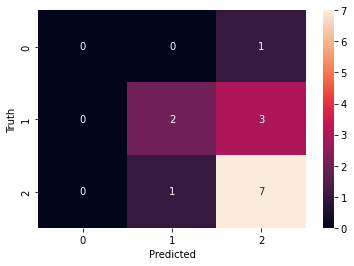

In [44]:
evaluate_model(X_test, y_test, model)

>**Task:**
>With the above starter code, a first improvement in accuracy compared to the SVM and the ANN using only Dense layers should be visible. However, the network could be further improved by adjusting the hyperparameters. Below you can find the full snippet from data preprocessing to model training. Play around with the parameters and see whether you can find a model that shows an even better performance!
>
>Some ideas are:
>- Explore different sized images (smaller/larger)
>- How do black and white images compare to the rgb ones?
>- Adapt the architecture of the neural network:
> - Change the amount of Conv2D layers
> - Change the number of filters in each layer
> - Explore other activation functions
>- Change the learning rate of the optimizer or look at different optimizers all together
>- Train the model for more epochs
>
>**For comparability, please don't change the ratios for train/test and train/validation!**

Epoch 1/75
4/4 [==============================] - 10s 2s/step - loss: 40.5017 - accuracy: 0.1600 - val_loss: 3.9183 - val_accuracy: 0.3333
Epoch 2/75
4/4 [==============================] - 16s 4s/step - loss: 24.0257 - accuracy: 0.3200 - val_loss: 1.9945 - val_accuracy: 0.6667
Epoch 3/75
4/4 [==============================] - 9s 2s/step - loss: 5.6048 - accuracy: 0.4800 - val_loss: 4.0347 - val_accuracy: 0.1667
Epoch 4/75
4/4 [==============================] - 8s 2s/step - loss: 4.4865 - accuracy: 0.1600 - val_loss: 4.8470 - val_accuracy: 0.1667
Epoch 5/75
4/4 [==============================] - 10s 2s/step - loss: 4.4644 - accuracy: 0.3400 - val_loss: 3.2798 - val_accuracy: 0.3333
Epoch 6/75
4/4 [==============================] - 8s 2s/step - loss: 2.8295 - accuracy: 0.3000 - val_loss: 1.4751 - val_accuracy: 0.1667
Epoch 7/75
4/4 [==============================] - 8s 2s/step - loss: 1.6098 - accuracy: 0.2200 - val_loss: 0.5909 - val_accuracy: 0.5000
Epoch 8/75
4/4 [====================

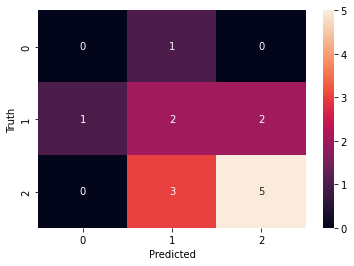

In [45]:
np.random.seed(28)

####################################################
# Please modify the following lines                #
# ! Don't change training/test/validation ratios ! #
####################################################

# Data preprocessing
features, labels = load_features_labels("./data/top", size=(512,512), color=True, flatten=False, identifiers=['MC', 'MS', 'C'])
features = np.array(features) # Datatype conversion of feature vector from list to array
labels = np.array(labels) # Datatype conversion of label vector from list to array
X_train, X_test, y_train, y_test = split_data(features, labels) # Split features and labels into training and testing datasets
y_train, y_test = encode_data(y_train, y_test) # Encode labels

# Model definition
model = Sequential()
model.add(Conv2D(4, 5,  input_shape = X_train[0].shape, activation = 'relu', padding="same"))
model.add(MaxPooling2D())
model.add(Conv2D(8, 3, activation = 'relu', padding="valid"))
model.add(MaxPooling2D())
model.add(Conv2D(16, 3, activation = 'relu', padding="valid"))
model.add(MaxPooling2D())
model.add(Conv2D(32, 3, activation = 'relu', padding="valid"))
model.add(GlobalMaxPooling2D())
model.add(Dense(32, activation = 'relu'))
model.add(Dense(y_train[0].shape[0], activation = 'softmax'))

# Model compilation
optimizer=Adam(learning_rate=0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

# Model training
model.fit(np.array(X_train), np.array(y_train), epochs = 75, batch_size = 15, validation_split=0.1, 
          verbose = 1, sample_weight=compute_sample_weight('balanced', y_train))

# Model evaluation
evaluate_model(X_test, y_test, model) 

### 1-5. Data Augmentation

In [47]:
# Data preprocessing
features, labels = load_features_labels("./data/top", size=(512,512), color=True, flatten=False, identifiers=['MC', 'MS', 'C'])
features = np.array(features) # Datatype conversion of feature vector from list to array
labels = np.array(labels) # Datatype conversion of label vector from list to array
X_train, X_test, y_train, y_test = split_data(features, labels) # Split features and labels into training and testing datasets
y_train, y_test = encode_data(y_train, y_test) # Encode labels

In [48]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [49]:
### Create and show data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

In [50]:
random_index = random.randint(0, len(features)) # Randomly select one image
datagen.fit(features[[random_index]]) # Fit the image generator with the randomly selected image

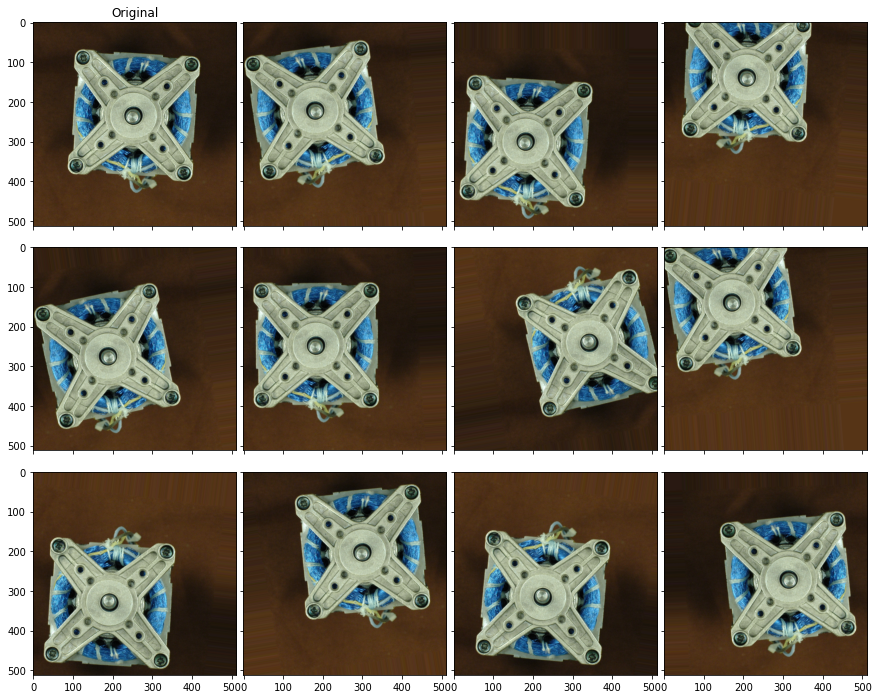

In [51]:
# Display the random augmentations
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(16, 12))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 4), axes_pad=(0.1, 0.3))

grid[0].imshow(features[random_index])
grid[0].set_title("Original")
for i, ax in enumerate(grid[1:]):
    image = datagen.flow(features[[random_index]]).next()[0].astype(int)
    ax.imshow(image) # Plot image
plt.show()

In [52]:
### Run model training with given data generator
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, train_size=0.9, stratify=y_train, random_state=21)

datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

datagen.fit(np.array(X_train))

model = Sequential()
model.add(Conv2D(8, 5,  input_shape = X_train[0].shape, activation = 'relu', padding="same"))
model.add(MaxPooling2D())
model.add(Conv2D(8, 5, activation = 'relu', padding="same"))
model.add(MaxPooling2D())
model.add(Conv2D(16, 5, activation = 'relu', padding="same"))
model.add(MaxPooling2D())
model.add(Conv2D(16, 3, activation = 'relu', padding="same"))
model.add(GlobalMaxPooling2D())
model.add(Dense(64, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(y_train[0].shape[0], activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

model.fit(datagen.flow(np.array(X_train), np.array(y_train), batch_size=8), validation_data=(X_validation, y_validation),
          steps_per_epoch=len(X_train) / 8, epochs=50)

Epoch 1/50
6/6 [==============================] - 14s 2s/step - loss: 14.8453 - accuracy: 0.1600 - val_loss: 2.4205 - val_accuracy: 0.1667
Epoch 2/50
6/6 [==============================] - 14s 2s/step - loss: 2.5023 - accuracy: 0.3200 - val_loss: 2.5166 - val_accuracy: 0.1667
Epoch 3/50
6/6 [==============================] - 14s 2s/step - loss: 2.0838 - accuracy: 0.5400 - val_loss: 0.7140 - val_accuracy: 0.8333
Epoch 4/50
6/6 [==============================] - 14s 2s/step - loss: 1.3925 - accuracy: 0.4200 - val_loss: 1.4213 - val_accuracy: 0.6667
Epoch 5/50
6/6 [==============================] - 14s 2s/step - loss: 1.7856 - accuracy: 0.5200 - val_loss: 0.9325 - val_accuracy: 0.5000
Epoch 6/50
6/6 [==============================] - 14s 2s/step - loss: 0.8905 - accuracy: 0.7200 - val_loss: 0.6691 - val_accuracy: 0.6667
Epoch 7/50
6/6 [==============================] - 14s 2s/step - loss: 0.9100 - accuracy: 0.6600 - val_loss: 0.7194 - val_accuracy: 0.6667
Epoch 8/50
6/6 [=================

               precision    recall  f1-score   support

     Complete       0.00      0.00      0.00         1
Missing cover       0.83      1.00      0.91         5
Missing screw       1.00      1.00      1.00         8

     accuracy                           0.93        14
    macro avg       0.61      0.67      0.64        14
 weighted avg       0.87      0.93      0.90        14



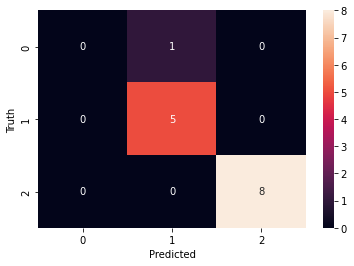

In [53]:
evaluate_model(X_test, y_test, model)

## 2- Expanding the project scope

> In the last part of the exercise, I expand the current quality monitoring solution to also detect not fully fastened screws. As mentioned, it might be useful to investigate the side view images to achieve this purpose. CNN executed on image dataset. 

Epoch 1/55
4/4 [==============================] - 19s 4s/step - loss: 9.8735 - accuracy: 0.2892 - val_loss: 1.0383 - val_accuracy: 0.4000
Epoch 2/55
4/4 [==============================] - 18s 4s/step - loss: 1.7676 - accuracy: 0.3494 - val_loss: 2.7489 - val_accuracy: 0.0000e+00
Epoch 3/55
4/4 [==============================] - 18s 4s/step - loss: 2.1705 - accuracy: 0.0482 - val_loss: 1.0902 - val_accuracy: 0.3000
Epoch 4/55
4/4 [==============================] - 18s 4s/step - loss: 1.1197 - accuracy: 0.3373 - val_loss: 0.6008 - val_accuracy: 0.4000
Epoch 5/55
4/4 [==============================] - 18s 4s/step - loss: 0.8224 - accuracy: 0.3614 - val_loss: 0.6356 - val_accuracy: 0.2000
Epoch 6/55
4/4 [==============================] - 18s 4s/step - loss: 0.7562 - accuracy: 0.2410 - val_loss: 0.6655 - val_accuracy: 0.1000
Epoch 7/55
4/4 [==============================] - 18s 4s/step - loss: 0.7961 - accuracy: 0.2410 - val_loss: 0.5813 - val_accuracy: 0.3000
Epoch 8/55
4/4 [==============

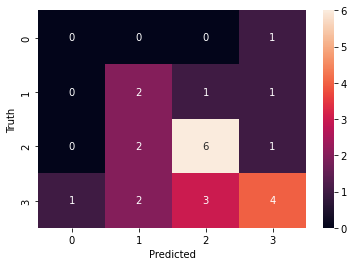

In [78]:
# Data preprocessing
features, labels = load_features_labels("./data/top", size=(512,512), color=True, flatten=False, identifiers=['MC', 'MS', 'C', 'NS'])
features = np.array(features) # Datatype conversion of feature vector from list to array
labels = np.array(labels) # Datatype conversion of label vector from list to array
X_train, X_test, y_train, y_test = split_data(features, labels) # Split features and labels into training and testing datasets
y_train, y_test = encode_data(y_train, y_test) # Encode labels

### Create and show data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)
datagen.fit(np.array(X_train))

# Model definition
model = Sequential()
model.add(Conv2D(8, 5,  input_shape = X_train[0].shape, activation = 'relu', padding="same"))
model.add(MaxPooling2D())
model.add(Conv2D(8, 5, activation = 'relu', padding="same"))
model.add(MaxPooling2D())
model.add(Conv2D(16, 5, activation = 'relu', padding="same"))
model.add(MaxPooling2D())
model.add(Conv2D(16, 3, activation = 'relu', padding="same"))
model.add(GlobalMaxPooling2D())
model.add(Dense(64, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(y_train[0].shape[0], activation = 'softmax'))

# Model compilation
optimizer=Adam(learning_rate=0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

# Model training
model.fit(np.array(X_train), np.array(y_train), epochs = 55, batch_size = 25, validation_split=0.1, 
          verbose = 1, sample_weight=compute_sample_weight('balanced', y_train))

# Model evaluation
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

y_test_arg=np.argmax(y_test,axis=1)
Y_pred = np.argmax(model.predict(X_test),axis=1)

cm = confusion_matrix(y_test_arg, Y_pred)
ax=sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
print(classification_report(y_test_arg, Y_pred))
